<a href="https://colab.research.google.com/github/piotrciechowicz/fake_news_detection/blob/main/Fake_news_detection_DS_FakeNewsNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score

!pip install pandas-profiling
from pandas_profiling import ProfileReport
from pathlib import Path
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Functions

In [18]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(texts):
    output= [i for i in texts if i not in stopwords]
    return output

In [19]:
interpunction = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', ':', ';', '<', '=', '>', '?', '@', '[', '', ']', '^', '_', '`', '{', '|', '}', '~']
def remove_interpunction(texts):
    output= [i for i in texts if i not in interpunction]
    return output

In [20]:
lemmatizer = WordNetLemmatizer()
def lemmatize(texts):
    lem_text = [lemmatizer.lemmatize(word) for word in texts]
    return lem_text

In [21]:
def test_model(X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0


  with torch.no_grad():
    correct_test = 0
    total_test = 0
    outputs_test = torch.squeeze(model(X_test))
    loss_test = criterion(outputs_test, y_test)

    predicted_test = outputs_test.round().detach().numpy()
    total_test += y_test.size(0)
    correct_test += np.sum(predicted_test == y_test.detach().numpy())
    accuracy_test = 100 * correct_test/total_test
    losses_test.append(loss_test.item())

    print(f"Test - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")

In [22]:
def use_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0

  for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
      x = X_train
      labels = y_train
      optimizer.zero_grad() 
      outputs = model(X_train)
      loss = criterion(torch.squeeze(outputs), labels) 
      
      loss.backward() 
      
      optimizer.step() 
      
      iter+=1
      if iter%(epochs/5)==0:
          with torch.no_grad():
              correct_test = 0
              total_test = 0
              outputs_test = torch.squeeze(model(X_test))
              loss_test = criterion(outputs_test, y_test)
              
              predicted_test = outputs_test.round().detach().numpy()
              total_test += y_test.size(0)
              correct_test += np.sum(predicted_test == y_test.detach().numpy())
              accuracy_test = 100 * correct_test/total_test
              losses_test.append(loss_test.item())
              total = 0
              correct = 0
              total += y_train.size(0)
              correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
              accuracy = 100 * correct/total
              losses.append(loss.item())
              Iterations.append(iter)

              print(f"Iteration: {iter}. \nVal - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
              print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
  return accuracy

In [23]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [24]:
def validation_with_StratifiedKFold(X_train, y_train, X_val, y_val, X_test, y_test, 
                                    n_splits, model, criterion, optimizer, epochs):

  skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 8)

  for fold,(train_idx,test_idx) in enumerate(skf.split(X_train, y_train)):

    print('\n')   
    print('------------fold no---------{}----------------------'.format(fold))
    print('\n')   

    x_train_fold, x_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    model_lr.apply(reset_weights)
    
    print('\n')    
    print('Fit model on train part of dataset')
    print('\n')  
    use_model(x_train_fold, y_train_fold, x_test_fold, y_test_fold, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on validation part of dataset')
    print('\n')  
    test_model(X_val, y_val, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on test part of dataset')
    print('\n') 
    test_model(X_test, y_test, 
               model, criterion, 
               optimizer, epochs)

#Importing dataset

In [25]:
path_fakenewsnet = '/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/Fake news net/FakeNewsNet.csv'
df = pd.read_csv(path_fakenewsnet)

In [26]:
df.sample(3)

,title,news_url,source_domain,tweet_num,real
17178,Patton Oswalt Opens Up After Arrest of Golden ...,https://people.com/crime/patton-oswalt-golden-...,people.com,81,1
21960,Justin Bieber & Baskin Champion Hit SoulCycle ...,https://hollywoodlife.com/2018/04/12/justin-bi...,hollywoodlife.com,94,1
19438,Judge Grants House Arrest for Track Palin Afte...,https://people.com/politics/track-palin-grante...,people.com,18,1


# Exploratory data analysis

In [27]:
df = df.rename({'real': 'is_real'}, axis='columns')

In [28]:
df_2 = df.drop(['news_url','source_domain','tweet_num'],axis=1)

In [29]:
print('Shape:')
print(df_2.shape)
print('-'*80, '\n')
print('Duplicates:')
print(df_2.duplicated().sum())
print('-'*80, '\n')
print('Missing values:')
print(df_2.isnull().sum())
print('-'*80, '\n')

Shape:
(23196, 2)
-------------------------------------------------------------------------------- 

Duplicates:
1349
-------------------------------------------------------------------------------- 

Missing values:
title      0
is_real    0
dtype: int64
-------------------------------------------------------------------------------- 



In [30]:
df_2 = df_2.drop_duplicates()

In [31]:
df_3 = df_2.dropna(axis='index')

In [32]:
print('Shape:')
print(df_3.shape)
print('-'*80, '\n')
print('Duplicates:')
print(df_3.duplicated().sum())
print('-'*80, '\n')
print('Missing values:')
print(df_3.isnull().sum())
print('-'*80, '\n')

Shape:
(21847, 2)
-------------------------------------------------------------------------------- 

Duplicates:
0
-------------------------------------------------------------------------------- 

Missing values:
title      0
is_real    0
dtype: int64
-------------------------------------------------------------------------------- 



1    16524
0     5323
Name: is_real, dtype: int64
-------------------------------------------------------------------------------- 



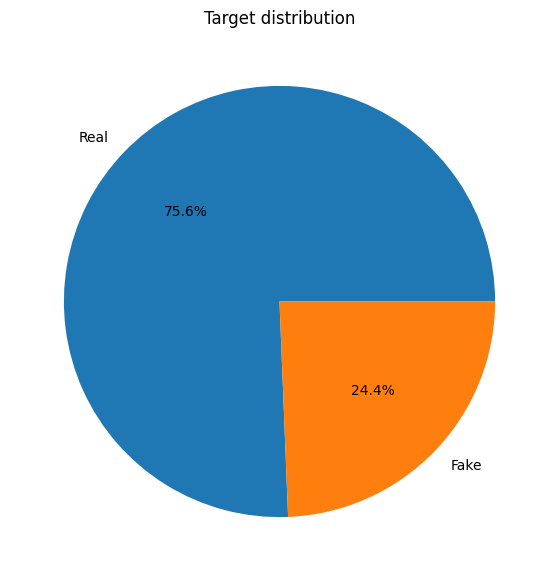

In [33]:
print(df_2['is_real'].value_counts())
print('-'*80, '\n')
fig, ax = plt.subplots(figsize = (7,7))
ax.pie(df_2['is_real'].value_counts(),labels=['Real','Fake'], autopct='%1.1f%%')
ax.set_title('Target distribution')
plt.show()

#Pandas profiling

In [34]:
prof = ProfileReport(df_2)
prof.to_file(Path("/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/pandas_profiling_report_fakenewsnet.html"))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#Feature engeneering

##Upsampling

In [35]:
df_3_fake = df_3[df_3['is_real']==0]
df_3_true = df_3[df_3['is_real']==1]

In [36]:
df_3_fake_upsample = resample(df_3_fake,
             replace=True,
             n_samples=len(df_3_true),
             random_state=42)

In [37]:
data = pd.concat([df_3_fake_upsample,df_3_true], ignore_index = True)

In [38]:
print(data['is_real'].value_counts())
print('-'*80, '\n')

0    16524
1    16524
Name: is_real, dtype: int64
-------------------------------------------------------------------------------- 



In [39]:
X_0 = data['title']
y = data['is_real']

##Lowering the text

In [40]:
X_low = X_0.map(lambda x: x.lower())

##Tokenization

In [41]:
X_tokenize = X_low.map(lambda x: word_tokenize(x))

##Removing stopwords

In [42]:
X_stopwords = X_tokenize.map(lambda x: remove_stopwords(x))

##Removing interpuntion

In [43]:
X_interpunction = X_stopwords.map(lambda x: remove_interpunction(x))

##Converting words to lemma

In [44]:
X_lemmatize = X_interpunction.map(lambda x: lemmatize(x))

#WordCloud

In [45]:
X = X_lemmatize.astype(str)

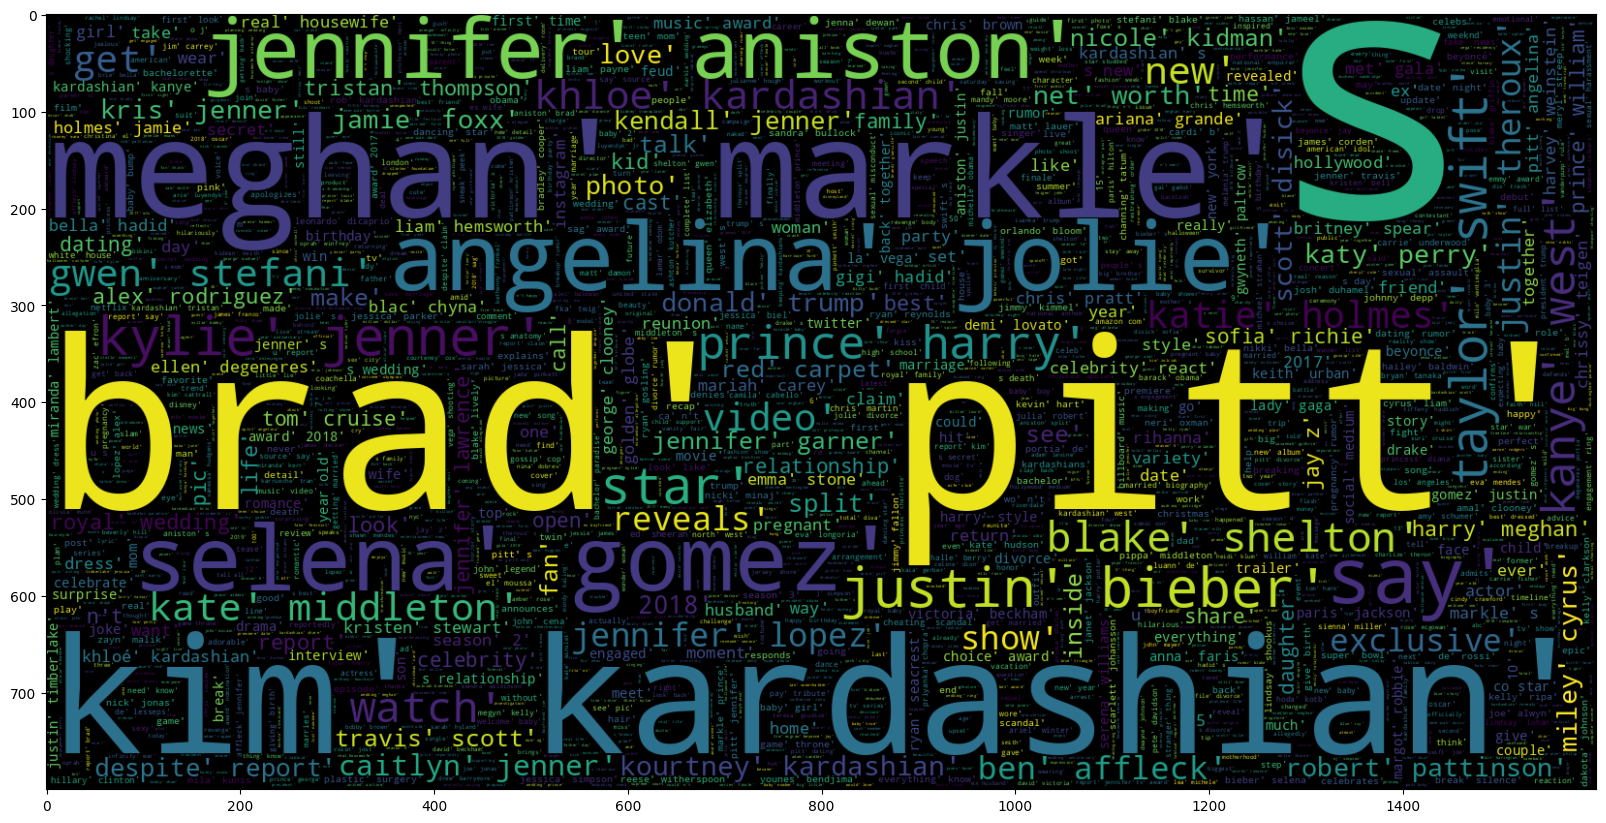

In [46]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(X))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

#Modeling

##Split dataset

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8, random_state = 8, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 8, stratify=y_test)

##TfidfVectorizer

In [48]:
tfidf = TfidfVectorizer(max_features=100)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

#Logistic Regression with PyTorch

###Model logistic regression

In [49]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [50]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
learning_rate = 0.01

In [51]:
model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

In [52]:
X_train_py, X_val_py, X_test_py = torch.Tensor(X_train_tfidf.toarray()),torch.Tensor(X_val_tfidf.toarray()),torch.Tensor(X_test_tfidf.toarray())
y_train_py, y_val_py, y_test_py = torch.Tensor(y_train.to_numpy()),torch.Tensor(y_val.to_numpy()),torch.Tensor(y_test.to_numpy())

In [53]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

Training Epochs:  21%|██        | 2082/10000 [00:03<00:09, 808.92it/s]

Iteration: 2000. 
Val - Loss: 0.6771915555000305. Accuracy: 66.05143721633888
Train -  Loss: 0.6771695017814636. Accuracy: 65.72855197458011



Training Epochs:  41%|████      | 4103/10000 [00:05<00:06, 857.40it/s]

Iteration: 4000. 
Val - Loss: 0.6650576591491699. Accuracy: 68.85022692889561
Train -  Loss: 0.6650707125663757. Accuracy: 68.37645634740505



Training Epochs:  61%|██████▏   | 6131/10000 [00:08<00:04, 888.56it/s]

Iteration: 6000. 
Val - Loss: 0.65465247631073. Accuracy: 69.4856278366112
Train -  Loss: 0.6546944379806519. Accuracy: 68.6185504614919



Training Epochs:  81%|████████  | 8103/10000 [00:10<00:02, 919.86it/s]

Iteration: 8000. 
Val - Loss: 0.6456865668296814. Accuracy: 69.96217851739789
Train -  Loss: 0.6457512974739075. Accuracy: 69.45074897866546



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 814.48it/s]

Iteration: 10000. 
Val - Loss: 0.637921929359436. Accuracy: 70.18154311649016
Train -  Loss: 0.6380037665367126. Accuracy: 69.72310485701317



69.72310485701317

###Optuna

In [54]:
def objective(trial):

  input_dim = X_train_tfidf.shape[1]
  output_dim = 1

  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}

  model_lr = LogisticRegression(input_dim,output_dim)
  criterion_lr = torch.nn.BCELoss()
  optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

  accuracy = use_model(X_train_py, y_train_py, X_val_py, y_val_py, 
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

  return accuracy

In [55]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=600)

[I 2023-04-17 16:38:06,874] A new study created in memory with name: no-name-edc41294-648d-404b-ba3d-e5872da6e896
<ipython-input-54-eca541b33e7e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}
Training Epochs:  21%|██        | 2091/10000 [00:03<00:13, 592.63it/s]

Iteration: 2000. 
Val - Loss: 0.6762372255325317. Accuracy: 66.85325264750378
Train -  Loss: 0.6766955256462097. Accuracy: 65.7739446209714



Training Epochs:  41%|████      | 4075/10000 [00:07<00:11, 521.80it/s]

Iteration: 4000. 
Val - Loss: 0.6642187237739563. Accuracy: 69.09228441754917
Train -  Loss: 0.6646907329559326. Accuracy: 67.99818429414435



Training Epochs:  62%|██████▏   | 6163/10000 [00:10<00:04, 897.39it/s]

Iteration: 6000. 
Val - Loss: 0.653910756111145. Accuracy: 69.54614220877458
Train -  Loss: 0.6543887257575989. Accuracy: 68.92116810410047



Training Epochs:  81%|████████  | 8123/10000 [00:12<00:02, 872.82it/s]

Iteration: 8000. 
Val - Loss: 0.6450266242027283. Accuracy: 69.92435703479576
Train -  Loss: 0.6455039978027344. Accuracy: 69.34483280375245



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 694.59it/s]
[I 2023-04-17 16:38:21,294] Trial 0 finished with value: 69.34483280375245 and parameters: {'lr': 0.09137676733313817}. Best is trial 0 with value: 69.34483280375245.


Iteration: 10000. 
Val - Loss: 0.6373307704925537. Accuracy: 69.92435703479576
Train -  Loss: 0.637801468372345. Accuracy: 69.34483280375245



Training Epochs:  21%|██▏       | 2146/10000 [00:02<00:08, 908.34it/s]

Iteration: 2000. 
Val - Loss: 0.6795065402984619. Accuracy: 64.66717095310136
Train -  Loss: 0.6789225339889526. Accuracy: 65.41080344984113



Training Epochs:  41%|████      | 4092/10000 [00:04<00:09, 591.79it/s]

Iteration: 4000. 
Val - Loss: 0.6670899391174316. Accuracy: 68.01815431164901
Train -  Loss: 0.6665651798248291. Accuracy: 67.69556665153578



Training Epochs:  61%|██████    | 6086/10000 [00:08<00:06, 566.24it/s]

Iteration: 6000. 
Val - Loss: 0.6564496159553528. Accuracy: 69.38729198184569
Train -  Loss: 0.6559739708900452. Accuracy: 69.07247692540476



Training Epochs:  81%|████████  | 8099/10000 [00:12<00:03, 495.55it/s]

Iteration: 8000. 
Val - Loss: 0.6472880244255066. Accuracy: 69.94704992435703
Train -  Loss: 0.6468520760536194. Accuracy: 69.32970192162203



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 690.96it/s]
[I 2023-04-17 16:38:35,778] Trial 1 finished with value: 69.46587986079588 and parameters: {'lr': 0.05601592867400481}. Best is trial 1 with value: 69.46587986079588.


Iteration: 10000. 
Val - Loss: 0.6393598318099976. Accuracy: 70.06807866868381
Train -  Loss: 0.6389549970626831. Accuracy: 69.46587986079588



Training Epochs:  21%|██▏       | 2148/10000 [00:02<00:08, 880.72it/s]

Iteration: 2000. 
Val - Loss: 0.6781418323516846. Accuracy: 65.21180030257186
Train -  Loss: 0.6778868436813354. Accuracy: 65.44106521410198



Training Epochs:  42%|████▏     | 4181/10000 [00:04<00:06, 900.99it/s]

Iteration: 4000. 
Val - Loss: 0.6659294962882996. Accuracy: 68.10136157337368
Train -  Loss: 0.6657059192657471. Accuracy: 68.36132546527463



Training Epochs:  61%|██████▏   | 6129/10000 [00:06<00:04, 920.26it/s]

Iteration: 6000. 
Val - Loss: 0.6554586887359619. Accuracy: 68.94099848714069
Train -  Loss: 0.6552607417106628. Accuracy: 68.96656075049175



Training Epochs:  81%|████████  | 8096/10000 [00:09<00:03, 553.21it/s]

Iteration: 8000. 
Val - Loss: 0.6464376449584961. Accuracy: 69.357034795764
Train -  Loss: 0.6462595462799072. Accuracy: 69.26917839310032



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 771.50it/s]
[I 2023-04-17 16:38:48,755] Trial 2 finished with value: 69.66258132849146 and parameters: {'lr': 0.042997477197071664}. Best is trial 2 with value: 69.66258132849146.


Iteration: 10000. 
Val - Loss: 0.6386259198188782. Accuracy: 69.81845688350984
Train -  Loss: 0.638462483882904. Accuracy: 69.66258132849146



Training Epochs:  22%|██▏       | 2155/10000 [00:03<00:10, 772.24it/s]

Iteration: 2000. 
Val - Loss: 0.6800865530967712. Accuracy: 65.09077155824508
Train -  Loss: 0.6801544427871704. Accuracy: 64.54834316840672



Training Epochs:  41%|████      | 4116/10000 [00:06<00:09, 637.03it/s]

Iteration: 4000. 
Val - Loss: 0.6675110459327698. Accuracy: 68.81996974281392
Train -  Loss: 0.6676310896873474. Accuracy: 68.39158722953549



Training Epochs:  61%|██████    | 6093/10000 [00:09<00:04, 865.78it/s]

Iteration: 6000. 
Val - Loss: 0.6567423939704895. Accuracy: 69.28895612708018
Train -  Loss: 0.6569030284881592. Accuracy: 68.86064457557876



Training Epochs:  82%|████████▏ | 8152/10000 [00:11<00:02, 850.16it/s]

Iteration: 8000. 
Val - Loss: 0.6474773287773132. Accuracy: 69.62934947049925
Train -  Loss: 0.6476678848266602. Accuracy: 69.07247692540476



Training Epochs: 100%|██████████| 10000/10000 [00:13<00:00, 735.50it/s]
[I 2023-04-17 16:39:02,366] Trial 3 finished with value: 69.23891662883946 and parameters: {'lr': 0.02434185439961175}. Best is trial 2 with value: 69.66258132849146.


Iteration: 10000. 
Val - Loss: 0.6394653916358948. Accuracy: 69.97730711043873
Train -  Loss: 0.6396765112876892. Accuracy: 69.23891662883946



Training Epochs:  21%|██        | 2104/10000 [00:03<00:14, 527.65it/s]

Iteration: 2000. 
Val - Loss: 0.6804399490356445. Accuracy: 65.0302571860817
Train -  Loss: 0.6808044910430908. Accuracy: 64.39703434710243



Training Epochs:  41%|████      | 4070/10000 [00:07<00:11, 517.43it/s]

Iteration: 4000. 
Val - Loss: 0.6678696274757385. Accuracy: 68.39636913767019
Train -  Loss: 0.668266773223877. Accuracy: 68.22514752610077



Training Epochs:  61%|██████    | 6115/10000 [00:10<00:04, 872.18it/s]

Iteration: 6000. 
Val - Loss: 0.6570971608161926. Accuracy: 69.08472012102874
Train -  Loss: 0.6575167775154114. Accuracy: 68.67907399001362



Training Epochs:  80%|███████▉  | 7985/10000 [00:12<00:02, 702.04it/s]

Iteration: 8000. 
Val - Loss: 0.6478215456008911. Accuracy: 69.1981845688351
Train -  Loss: 0.6482546329498291. Accuracy: 68.6185504614919



Training Epochs: 100%|██████████| 10000/10000 [00:16<00:00, 611.43it/s]
[I 2023-04-17 16:39:18,732] Trial 4 finished with value: 69.05734604327432 and parameters: {'lr': 0.0427365187223338}. Best is trial 2 with value: 69.66258132849146.


Iteration: 10000. 
Val - Loss: 0.6397947072982788. Accuracy: 69.40242057488653
Train -  Loss: 0.6402336955070496. Accuracy: 69.05734604327432



In [56]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 69.66258132849146
  Params: 
    lr: 0.042997477197071664


###StratifiedKFold

In [57]:
lr_best = trial.params['lr']
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [58]:
validation_with_StratifiedKFold(X_train_py, y_train_py,
                                X_val_py, y_val_py, 
                                X_test_py, y_test_py, 
                                n_splits = 5, model = model_lr, 
                                criterion = criterion_lr, optimizer = optimizer_lr, epochs = 10000)



------------fold no---------0----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2088/10000 [00:02<00:09, 791.60it/s]

Iteration: 2000. 
Val - Loss: 0.6442126631736755. Accuracy: 68.910741301059
Train -  Loss: 0.6453222036361694. Accuracy: 69.62360506903727



Training Epochs:  41%|████      | 4097/10000 [00:05<00:08, 693.50it/s]

Iteration: 4000. 
Val - Loss: 0.6182504296302795. Accuracy: 69.21331316187594
Train -  Loss: 0.6187909841537476. Accuracy: 69.8316625685644



Training Epochs:  61%|██████    | 6112/10000 [00:08<00:06, 603.64it/s]

Iteration: 6000. 
Val - Loss: 0.603240966796875. Accuracy: 69.44024205748866
Train -  Loss: 0.6030648946762085. Accuracy: 70.03972006809154



Training Epochs:  81%|████████▏ | 8127/10000 [00:11<00:01, 993.30it/s]

Iteration: 8000. 
Val - Loss: 0.5939396023750305. Accuracy: 69.44024205748866
Train -  Loss: 0.5930345058441162. Accuracy: 70.09646302250803



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 780.06it/s]


Iteration: 10000. 
Val - Loss: 0.587860107421875. Accuracy: 69.28895612708018
Train -  Loss: 0.586263120174408. Accuracy: 70.02080574995271



Evaluation model on validation part of dataset


Test - Loss: 0.5869842171669006. Accuracy: 70.16641452344932


Evaluation model on test part of dataset


Test - Loss: 0.5879138708114624. Accuracy: 70.14902791436569


------------fold no---------1----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██▏       | 2132/10000 [00:02<00:07, 1047.63it/s]

Iteration: 2000. 
Val - Loss: 0.6477253437042236. Accuracy: 67.8517397881997
Train -  Loss: 0.6426993608474731. Accuracy: 69.45337620578778



Training Epochs:  42%|████▏     | 4154/10000 [00:04<00:05, 1029.47it/s]

Iteration: 4000. 
Val - Loss: 0.6239131689071655. Accuracy: 68.15431164901665
Train -  Loss: 0.6161223649978638. Accuracy: 70.00189143181389



Training Epochs:  61%|██████    | 6111/10000 [00:05<00:03, 1050.65it/s]

Iteration: 6000. 
Val - Loss: 0.6101625561714172. Accuracy: 68.45688350983359
Train -  Loss: 0.6004102230072021. Accuracy: 70.1342916587857



Training Epochs:  81%|████████  | 8117/10000 [00:07<00:02, 752.40it/s]

Iteration: 8000. 
Val - Loss: 0.6016361117362976. Accuracy: 69.06202723146747
Train -  Loss: 0.5904039144515991. Accuracy: 70.38017779459051



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 932.38it/s]


Iteration: 10000. 
Val - Loss: 0.5960502624511719. Accuracy: 69.21331316187594
Train -  Loss: 0.5836519598960876. Accuracy: 70.436920749007



Evaluation model on validation part of dataset


Test - Loss: 0.5854085683822632. Accuracy: 70.62027231467474


Evaluation model on test part of dataset


Test - Loss: 0.5868271589279175. Accuracy: 70.36084423935245


------------fold no---------2----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2071/10000 [00:03<00:12, 623.95it/s]

Iteration: 2000. 
Val - Loss: 0.6491180062294006. Accuracy: 67.70045385779123
Train -  Loss: 0.6432773470878601. Accuracy: 69.54794779648194



Training Epochs:  41%|████▏     | 4143/10000 [00:05<00:05, 1046.06it/s]

Iteration: 4000. 
Val - Loss: 0.6254661679267883. Accuracy: 68.30559757942511
Train -  Loss: 0.6159937381744385. Accuracy: 70.24777756761868



Training Epochs:  61%|██████▏   | 6145/10000 [00:07<00:03, 1010.14it/s]

Iteration: 6000. 
Val - Loss: 0.612193763256073. Accuracy: 67.92738275340393
Train -  Loss: 0.5998006463050842. Accuracy: 70.55040665783999



Training Epochs:  82%|████████▏ | 8194/10000 [00:09<00:01, 1076.41it/s]

Iteration: 8000. 
Val - Loss: 0.6042590737342834. Accuracy: 67.8517397881997
Train -  Loss: 0.5894566178321838. Accuracy: 70.51257802156232



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 861.27it/s]


Iteration: 10000. 
Val - Loss: 0.5992893576622009. Accuracy: 68.00302571860817
Train -  Loss: 0.5824626684188843. Accuracy: 70.56932097597881



Evaluation model on validation part of dataset


Test - Loss: 0.5856010317802429. Accuracy: 70.6732223903177


Evaluation model on test part of dataset


Test - Loss: 0.5864465236663818. Accuracy: 70.3759739768515


------------fold no---------3----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██▏       | 2145/10000 [00:02<00:07, 1000.42it/s]

Iteration: 2000. 
Val - Loss: 0.6466452479362488. Accuracy: 69.1376701966717
Train -  Loss: 0.6437944769859314. Accuracy: 69.47229052392662



Training Epochs:  41%|████      | 4120/10000 [00:04<00:07, 786.02it/s]

Iteration: 4000. 
Val - Loss: 0.6215066313743591. Accuracy: 69.36459909228442
Train -  Loss: 0.6174700856208801. Accuracy: 69.41554756951012



Training Epochs:  61%|██████    | 6104/10000 [00:08<00:12, 307.17it/s]

Iteration: 6000. 
Val - Loss: 0.606631875038147. Accuracy: 69.59152798789712
Train -  Loss: 0.602016806602478. Accuracy: 69.56686211462076



Training Epochs:  81%|████████  | 8098/10000 [00:12<00:03, 615.69it/s]

Iteration: 8000. 
Val - Loss: 0.5971575379371643. Accuracy: 70.42360060514372
Train -  Loss: 0.5922060608863831. Accuracy: 69.90731984111973



Training Epochs: 100%|██████████| 10000/10000 [00:14<00:00, 685.92it/s]


Iteration: 10000. 
Val - Loss: 0.5907823443412781. Accuracy: 70.42360060514372
Train -  Loss: 0.5855923891067505. Accuracy: 70.02080574995271



Evaluation model on validation part of dataset


Test - Loss: 0.587131917476654. Accuracy: 70.55219364599093


Evaluation model on test part of dataset


Test - Loss: 0.5875733494758606. Accuracy: 70.39110371435055


------------fold no---------4----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2112/10000 [00:02<00:07, 1005.01it/s]

Iteration: 2000. 
Val - Loss: 0.6433738470077515. Accuracy: 69.19000757002271
Train -  Loss: 0.6431362628936768. Accuracy: 69.95083207261725



Training Epochs:  42%|████▏     | 4152/10000 [00:04<00:05, 1060.23it/s]

Iteration: 4000. 
Val - Loss: 0.618592381477356. Accuracy: 69.41710825132475
Train -  Loss: 0.6170969605445862. Accuracy: 70.23449319213313



Training Epochs:  62%|██████▏   | 6185/10000 [00:06<00:03, 988.40it/s]

Iteration: 6000. 
Val - Loss: 0.6042020916938782. Accuracy: 69.11430734292203
Train -  Loss: 0.6015589237213135. Accuracy: 70.21558245083207



Training Epochs:  81%|████████▏ | 8130/10000 [00:07<00:01, 1020.18it/s]

Iteration: 8000. 
Val - Loss: 0.59531170129776. Accuracy: 69.03860711582135
Train -  Loss: 0.5915789604187012. Accuracy: 70.13993948562783



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 948.17it/s]

Iteration: 10000. 
Val - Loss: 0.5895686745643616. Accuracy: 69.03860711582135
Train -  Loss: 0.5847930312156677. Accuracy: 70.13993948562783



Evaluation model on validation part of dataset


Test - Loss: 0.586321234703064. Accuracy: 70.27987897125567


Evaluation model on test part of dataset


Test - Loss: 0.5875444412231445. Accuracy: 70.17172252061427


###Without cutting "stopwords'

In [59]:
X_interpunction_2 = X_tokenize.map(lambda x: remove_interpunction(x))
X_lemmatize_2 = X_interpunction_2.map(lambda x: lemmatize(x))
X_2 = X_lemmatize_2.astype(str)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_2 = tfidf.fit_transform(X_train_2)
X_val_tfidf_2 = tfidf.transform(X_val_2)

In [60]:
input_dim = X_train_tfidf_2.shape[1]
output_dim = 1
lr = lr_best

model_lr_2 = LogisticRegression(input_dim,output_dim)
criterion_lr_2 = torch.nn.BCELoss()
optimizer_lr_2 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [61]:
X_train_py_2, X_val_py_2 = torch.Tensor(X_train_tfidf_2.toarray()),torch.Tensor(X_val_tfidf_2.toarray())
y_train_py_2, y_val_py_2 = torch.Tensor(y_train_2.to_numpy()),torch.Tensor(y_val_2.to_numpy())

In [62]:
use_model(X_train_py_2, y_train_py_2, X_val_py_2, y_val_py_2,
          model = model_lr_2, criterion = criterion_lr_2, 
          optimizer = optimizer_lr_2, epochs = 10000)

Training Epochs:  22%|██▏       | 2170/10000 [00:02<00:08, 935.99it/s]

Iteration: 2000. 
Val - Loss: 0.6938073635101318. Accuracy: 50.20613487650819
Train -  Loss: 0.6938477158546448. Accuracy: 50.38583749432592



Training Epochs:  41%|████▏     | 4125/10000 [00:04<00:06, 933.58it/s]

Iteration: 4000. 
Val - Loss: 0.6938073635101318. Accuracy: 50.20613487650819
Train -  Loss: 0.6938477158546448. Accuracy: 50.38583749432592



Training Epochs:  62%|██████▏   | 6177/10000 [00:06<00:04, 919.68it/s]

Iteration: 6000. 
Val - Loss: 0.6938073635101318. Accuracy: 50.20613487650819
Train -  Loss: 0.6938477158546448. Accuracy: 50.38583749432592



Training Epochs:  82%|████████▏ | 8189/10000 [00:09<00:01, 925.98it/s]

Iteration: 8000. 
Val - Loss: 0.6938073635101318. Accuracy: 50.20613487650819
Train -  Loss: 0.6938477158546448. Accuracy: 50.38583749432592



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 898.04it/s]

Iteration: 10000. 
Val - Loss: 0.6938073635101318. Accuracy: 50.20613487650819
Train -  Loss: 0.6938477158546448. Accuracy: 50.38583749432592



50.38583749432592

###Without lemmatization

In [63]:
X_3 = X_interpunction.astype(str)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_3 = tfidf.fit_transform(X_train_3)
X_val_tfidf_3 = tfidf.transform(X_val_3)

In [64]:
input_dim = X_train_tfidf_3.shape[1]
output_dim = 1
lr = lr_best

model_lr_3 = LogisticRegression(input_dim,output_dim)
criterion_lr_3 = torch.nn.BCELoss()
optimizer_lr_3 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [65]:
X_train_py_3, X_val_py_3 = torch.Tensor(X_train_tfidf_3.toarray()),torch.Tensor(X_val_tfidf_3.toarray())
y_train_py_3, y_val_py_3 = torch.Tensor(y_train_3.to_numpy()),torch.Tensor(y_val_3.to_numpy())

In [66]:
use_model(X_train_py_3, y_train_py_3, X_val_py_3, y_val_py_3,
          model = model_lr_3, criterion = criterion_lr_3, 
          optimizer = optimizer_lr_3, epochs = 10000)

Training Epochs:  21%|██        | 2056/10000 [00:03<00:13, 568.87it/s]

Iteration: 2000. 
Val - Loss: 0.6923193335533142. Accuracy: 52.75161692953591
Train -  Loss: 0.6920493841171265. Accuracy: 52.64033893175972



Training Epochs:  41%|████      | 4075/10000 [00:07<00:11, 532.68it/s]

Iteration: 4000. 
Val - Loss: 0.6923193335533142. Accuracy: 52.75161692953591
Train -  Loss: 0.6920493841171265. Accuracy: 52.64033893175972



Training Epochs:  62%|██████▏   | 6166/10000 [00:09<00:04, 934.90it/s]

Iteration: 6000. 
Val - Loss: 0.6923193335533142. Accuracy: 52.75161692953591
Train -  Loss: 0.6920493841171265. Accuracy: 52.64033893175972



Training Epochs:  82%|████████▏ | 8188/10000 [00:11<00:01, 943.68it/s]

Iteration: 8000. 
Val - Loss: 0.6923193335533142. Accuracy: 52.75161692953591
Train -  Loss: 0.6920493841171265. Accuracy: 52.64033893175972



Training Epochs: 100%|██████████| 10000/10000 [00:13<00:00, 737.20it/s]

Iteration: 10000. 
Val - Loss: 0.6923193335533142. Accuracy: 52.75161692953591
Train -  Loss: 0.6920493841171265. Accuracy: 52.64033893175972



52.64033893175972

#Deeper neutral network

In [67]:
class DeeperNN(nn.Module):

  def __init__(self, input_dim, output_dim):
      super().__init__()
      self.layer1 = nn.Linear(input_dim, 60)
      self.act1 = nn.ReLU()
      self.layer2 = nn.Linear(60, 60)
      self.act2 = nn.ReLU()
      self.layer3 = nn.Linear(60, 60)
      self.act3 = nn.ReLU()
      self.output = nn.Linear(60, output_dim)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.act1(self.layer1(x))
      x = self.act2(self.layer2(x))
      x = self.act3(self.layer3(x))
      x = self.sigmoid(self.output(x))
      return x

In [68]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_nn = DeeperNN(input_dim,output_dim)
criterion_nn = torch.nn.BCELoss()
optimizer_nn = torch.optim.SGD(model_nn.parameters(), lr=lr)

In [69]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_nn, criterion = criterion_nn, 
          optimizer = optimizer_nn, epochs = 10000)

Training Epochs:  20%|██        | 2010/10000 [00:40<02:16, 58.48it/s]

Iteration: 2000. 
Val - Loss: 0.691592276096344. Accuracy: 62.01210287443268
Train -  Loss: 0.6916161179542542. Accuracy: 61.67347556362536



Training Epochs:  40%|████      | 4006/10000 [01:21<02:36, 38.26it/s]

Iteration: 4000. 
Val - Loss: 0.5744345784187317. Accuracy: 70.37065052950075
Train -  Loss: 0.5726469159126282. Accuracy: 69.7987592676653



Training Epochs:  60%|██████    | 6005/10000 [02:03<01:50, 36.28it/s]

Iteration: 6000. 
Val - Loss: 0.5640599727630615. Accuracy: 70.62783661119516
Train -  Loss: 0.5573863983154297. Accuracy: 71.02436072022999



Training Epochs:  80%|████████  | 8006/10000 [02:43<00:36, 54.35it/s]

Iteration: 8000. 
Val - Loss: 0.5611213445663452. Accuracy: 70.82450832072617
Train -  Loss: 0.5483508706092834. Accuracy: 71.37237100922984



Training Epochs: 100%|██████████| 10000/10000 [03:23<00:00, 49.14it/s]

Iteration: 10000. 
Val - Loss: 0.5685379505157471. Accuracy: 70.52950075642966
Train -  Loss: 0.5388972163200378. Accuracy: 72.4769254047511



72.4769254047511

#Similar news

In [70]:
X_emb = X[0:100]

In [71]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(X_emb)

In [72]:
cos_sim = util.cos_sim(embeddings, embeddings)

all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(X_emb[i], X_emb[j], cos_sim[i][j]))

Top-5 most similar pairs:
['kylie', 'jenner', 'major', 'regret', 'pregnancy', 'travis', 'scott', '—', 'tyga', '’', 'baby'] 	 ['kylie', 'jenner', '``', 'cool', "''", 'travis', 'scott', 'taking', '``', 'parenting', 'break', "''", 'hollywood', 'buzz'] 	 0.9401
['kim', 'kardashian', '‘', 'furious', '’', 'travis', 'scott', 'neglecting', 'pregnant', 'kylie', 'jenner'] 	 ['kylie', 'jenner', 'major', 'regret', 'pregnancy', 'travis', 'scott', '—', 'tyga', '’', 'baby'] 	 0.9212
['report', 'ryan', 'gosling', 'eva', 'mendes', 'split'] 	 ['ryan', 'gosling', 'pregnant', 'love', 'eva', 'mendes', "'have", 'broken'] 	 0.9155
['kim', 'kardashian', '‘', 'furious', '’', 'travis', 'scott', 'neglecting', 'pregnant', 'kylie', 'jenner'] 	 ['kylie', 'jenner', '``', 'cool', "''", 'travis', 'scott', 'taking', '``', 'parenting', 'break', "''", 'hollywood', 'buzz'] 	 0.8978
['justin', 'bieber', 'accidentally', 'hit', 'photographer', 'pick-up', 'truck', 'church', 'service'] 	 ['justin', 'bieber', 'pedophile', 'run'